# Processing ERA5 data with Dask & AWS Fargate

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
from dask.distributed import performance_report
from dask.distributed import Client

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Scale out Dask Workers

In [2]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:816257832715:cluster/era-Fargate-Dask-Cluster'

You will need to update the `--cluster` option in the comamnd below to make your cluster name from above

In [3]:
numWorkers=10
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [4]:
client = Client('Dask-Scheduler.local-dask:8786')
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 10 Cores: 20 Memory: 70.00 GB


## Open an Example File and Check the Native Chunking

We want to chunk in a similar way for maximum performance

In [5]:
url = 's3://era5-pds/2010/01/data/air_temperature_at_2_metres.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())

ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': <File-like object S3FileSystem, era5-pds/2010/01/data/air_temperature_at_2_metres.nc>,
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': array([9.96921e+36], dtype=float32)}

## Open January 2-m air temperature for 10 years as a single dataset

In [6]:
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
file_pattern = 's3://era5-pds/{year}/01/data/air_temperature_at_2_metres.nc'

fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
files_mapper = [fs.open(file_pattern.format(year=year)) for year in years]

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':200,'lat':200,'time0':720})
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 33.99



/home/ec2-user/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel/__main__.py:7: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/home/ec2-user/anaconda3/envs/python3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lat: 721, lon: 1440, time0: 8184)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.75
  * time0                        (time0) datetime64[ns] 2010-01-01 ... 2020-01-31T23:00:00
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(720, 200, 200), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

## Convert units to F from K

In [7]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15) * 9.0 / 5.0 + 32.0
ds.air_temperature_at_2_metres.attrs['units'] = 'F'

## Calculate the mean 2-m air temperature for all January

In [8]:
# calculates the monthly mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [9]:
%%time

with performance_report(filename="dask-report.html"):
    temp_mean = temp_mean.compute()

CPU times: user 723 ms, sys: 94.8 ms, total: 818 ms
Wall time: 3min 3s


### Plot Average Surface Temperature

Text(0.5, 1.0, 'January 2010-2020 Mean 2-m Air Temperature')

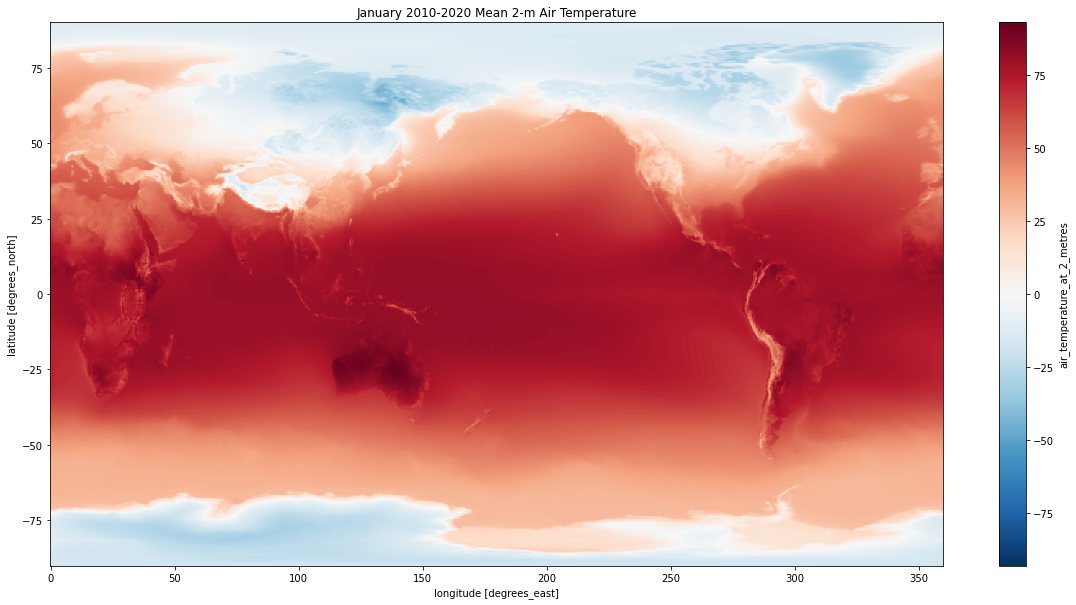

In [10]:
temp_mean.plot(figsize=(20, 10))
plt.title('January 2010-2020 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [11]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='time0')

In [12]:
%time temp_std = temp_std.compute()

CPU times: user 629 ms, sys: 94.3 ms, total: 723 ms
Wall time: 2min 50s


Text(0.5, 1.0, 'January 2010-2020 Standard Deviation 2-m Air Temperature')

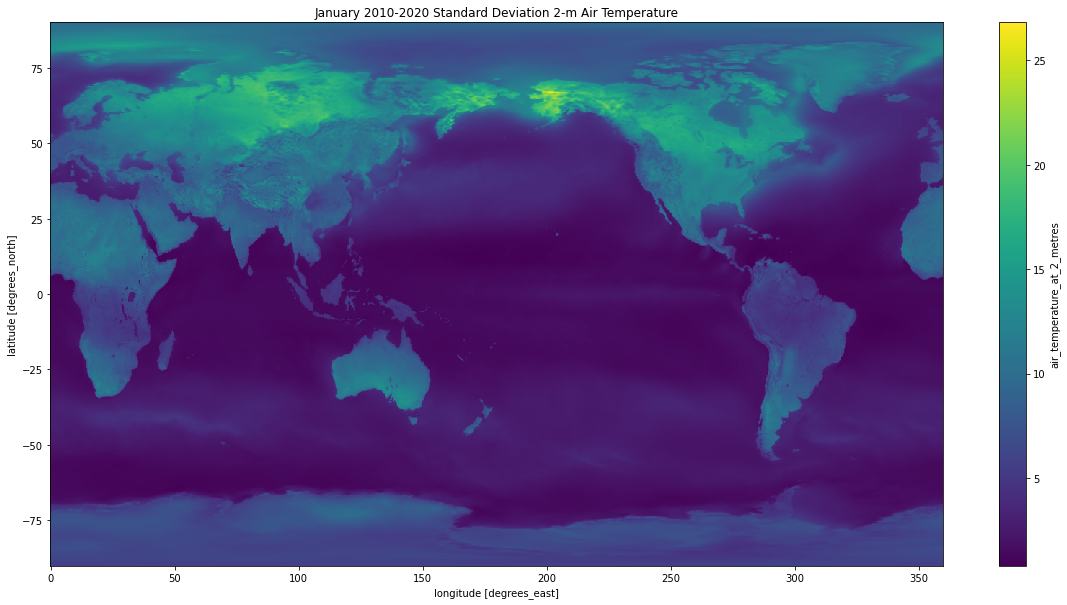

In [13]:
temp_std.plot(figsize=(20, 10))
plt.title('January 2010-2020 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [14]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [15]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>

### Convert to dataframe

In [16]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle
count,8184.000000,8184.000000,8184.000000,8184.000000
mean,53.527256,27.399048,73.358917,42.278454
std,7.132222,12.359817,1.541849,5.969839
min,35.105011,-14.057487,66.605011,21.267511
25%,48.605011,20.339386,72.455009,38.480011
50%,52.880013,27.117512,73.467514,43.205009
75%,57.942513,35.217510,74.480011,46.467510
max,77.292511,62.217510,76.955009,57.942513


## Plot January temperatures

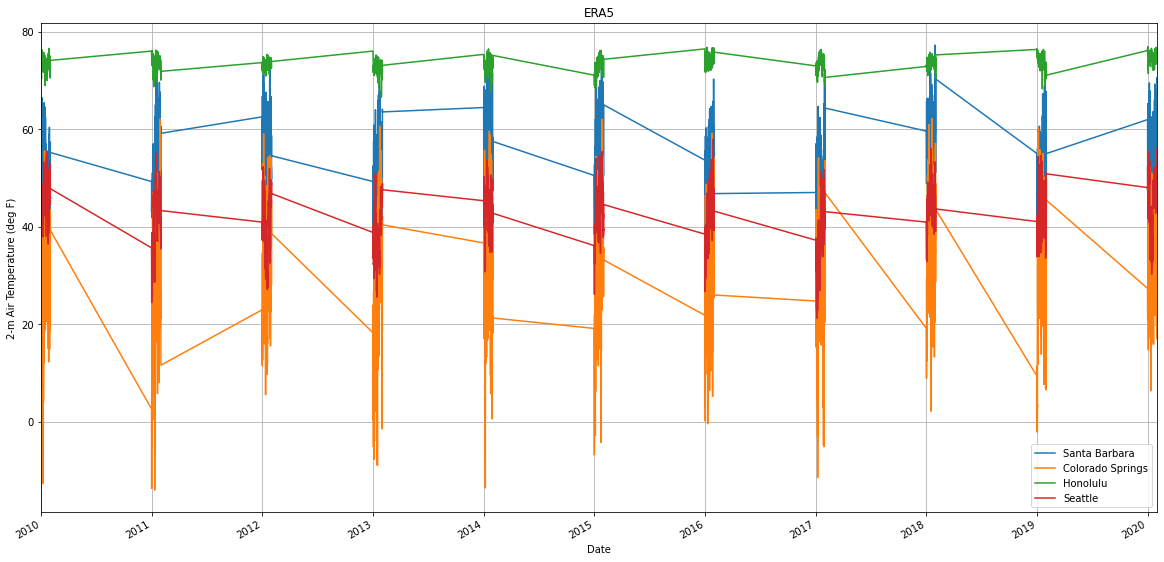

In [17]:
ax = df_f.plot(figsize=(20, 10), title="ERA5", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [18]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])